<a href="https://colab.research.google.com/github/fdluiuc/lecture-notebooks/blob/master/01c-linear-regression-with-gradient-descent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overview 

Within this notebook, we walk through implementing a custom simple linear regression using results from both the normal equations and gradient descent. Please note, this notebook emphasizes regression using `NumPy`.

## Diagnostics


In [1]:
#@title (Hidden) Diagnostic Check
import os
import sys
import pandas as pd
import numpy as np
%tensorflow_version 2.x
import statsmodels 
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib
import matplotlib.pyplot as plt

print(f"\nPython environment:\n{sys.version}")
print("\nStatistical packages loaded: ")
print(f"pandas: {pd.__version__}")
print(f"numpy: {np.__version__}")
print(f"statsmodels: {statsmodels.__version__}")
print(f"matplotlib: {matplotlib.__version__}")

print(f"\nRuntime location:")
try:
  from google.colab import drive
  is_google_colab = True
  print("Notebook is on Google CoLab")
except:
  is_google_colab = False
  print("Notebook is being run locally or through another source.")


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm



Python environment:
3.7.12 (default, Sep 10 2021, 00:21:48) 
[GCC 7.5.0]

Statistical packages loaded: 
pandas: 1.1.5
numpy: 1.19.5
statsmodels: 0.10.2
matplotlib: 3.2.2

Runtime location:
Notebook is on Google CoLab


## Simulating Data

Prior to continuing, we need to simulate data. We repeat the process described in the previous notebook.

In [2]:
import numpy as np
import pandas as pd

# Set parameters
true_theta_0 = -1
true_theta_1 = 3
n = 50

# Set seed for reproducibility
np.random.seed(831)

# Generate design matrix
X = np.arange(0, n, 1)*2/n

# Create relationship
Y = true_theta_0 + true_theta_1*X 

# Add error
error = np.random.randn(n)
Y = Y + error


## Custom implementation of simple linear regression's closed-form solution

The closed form for simple linear regression can be derived to:

$$\begin{align}
\hat{\beta}_1 &= \frac{\sum_{i=1}^{n}{(x_i - \bar x)(y_i - \bar y)}}{\sum_{i=1}^{n}{(x_i - \bar x)^2}} \\
\hat{\beta}_0 &= \bar{y} - \hat{\beta}_1\bar{x} \\
\end{align}$$

With a closed-form solution, we can quickly write a function that computes the desired outcome.

In [3]:
import numpy as np

def slr_ne(X, Y):
  x_bar = np.mean(X)  # Compute mean for X
  y_bar = np.mean(Y)  # Compute mean for Y
  
  # Calculate beta1
  hat_beta_1 = np.sum((X - x_bar)*(Y - y_bar))/np.sum((X - x_bar)**2)
  # Calculate beta0
  hat_beta_0 = y_bar - hat_beta_1*x_bar

  # Return values
  return hat_beta_0, hat_beta_1

Once the function is implemented, we can use it to obtain parameter estimates for $\beta_0$ and $\beta_1$.

In [4]:
# Compute parameter estimates
hat_beta_0, hat_beta_1 = slr_ne(X, Y)

In [5]:
#@title Estimated values from Normal Equations
from IPython.display import display, Markdown
# Display guesses in a nicely formatted manner
display(Markdown(
rf"""

Estimated values for """r"""$\boldsymbol{\beta}$"""

rf"""
- $\hat\beta_0$ = {hat_beta_0:.04f}
- $\hat\beta_1$ = {hat_beta_1:.04f}
"""
))



Estimated values for $\boldsymbol{\beta}$
- $\hat\beta_0$ = -1.6288
- $\hat\beta_1$ = 3.4460


The next step in the process is creating predictions when given new data: 

$$\hat y = \hat\beta_0 + \hat\beta_1 x$$

In [6]:
# Compute a prediction
def slr_predict(hat_beta_0, hat_beta_1, X):
  y_hat = hat_beta_0 + hat_beta_1*X
  return y_hat

If a new data point becomes available, say $x = 3$, then we would have: 


In [7]:
x = 3
y_hat_at_x = slr_predict(hat_beta_0, hat_beta_1, x)

In [8]:
#@title Predicted value at x
# Display guesses in a nicely formatted manner
display(Markdown(
rf"""

Estimated values for $x = 3$ is:

$\hat y = \hat\beta_0 + \hat\beta_1 x = {hat_beta_0:.04f} + {hat_beta_1:.04f}\left({x}\right) = {y_hat_at_x:.04f}$
"""
))



Estimated values for $x = 3$ is:

$\hat y = \hat\beta_0 + \hat\beta_1 x = -1.6288 + 3.4460\left(3\right) = 8.7091$


Creating a prediction for each data point under the estimated simple linear regression parameters results in a graph similar to what was achieved with the `scikit-learn` implementation of linear regression.

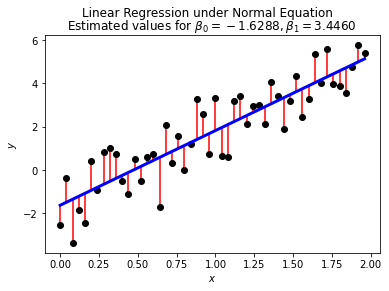

In [9]:
# Create prediction 
Y_hat = slr_predict(hat_beta_0, hat_beta_1, X)

# Show residual lines
plt.vlines(X, Y, Y_hat, color="red", zorder = 1)
# Show data points
plt.scatter(X, Y,  color='black', zorder = 2)
# Graph the line of best fit
plt.plot(X, Y_hat, color='blue', linewidth = 3, zorder = 3)
# Plot details
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(rf"Estimated values for $\beta_0 = {hat_beta_0:.04f}, \beta_1 = {hat_beta_1:.04f}$ ")
plt.suptitle('Linear Regression under Normal Equation')
# Show graph
plt.show()

## Linear Regression under Numerical Optimization

In this section, we pretend as if we never saw the normal equations. Instead, we work on providing estimates using only numerical optimization techniques on the cost function. In the case of linear regression, we're defining the cost function in matrix-form as: 

$$
\begin{align}
J\left(\mathbf{\theta}\right) &= \underset{\theta}{\operatorname{argmin}}\; (\mathbf{y} - \mathbf{X}\mathbf{\theta})^T(\mathbf{y} - \mathbf{X}\mathbf{\theta}) \\
&= \underset{\theta}{\operatorname{argmin}}\; \lVert \mathbf{y} - \mathbf{X}\mathbf{\theta} \lVert^2
\end{align}
$$

**Note:** Only _notational_ changes have been made compared to the previously present matrix-form for Normal equations.

$$
\begin{align}
\hat{\mathbf{\beta}}_{p \times 1} &= \underset{\beta}{\operatorname{argmin}}\; (\mathbf{y} - \mathbf{X}\mathbf{\beta})^T(\mathbf{y} - \mathbf{X}\mathbf{\beta}) \\
&= \underset{\beta}{\operatorname{argmin}}\; \lVert \mathbf{y} - \mathbf{X}\mathbf{\beta} \lVert^2
\end{align}
$$


### Minimization of the Sum of Squares

When viewing a minimization problem, we're seeking to find the function's **smallest** value. But, what does that mean exactly in the context of regression? Well, given a line and scattered points, the smallest distance to each point from the line is desired. 

That is, we want the defined sum of squares value $D = \frac{1}{n}\sum_{i = 1}^{n} e_i^2$ to be as close to zero as possible. Note, $D$ is a single real-valued number like 1.2132. 

The bottom line: the closer to zero, the better.




## Cost function for SLR 

For the SLR case, we are trying to minimize a two-parameter cost function:

\begin{align}
 J(\boldsymbol\theta) &= \frac{1}{n} \sum_{i=1}^n (y_i - \hat{y_i})^2 \\
 & = \frac{1}{n} \sum_{i=1}^n \left[y_i - \left(\hat\theta_0 + \hat \theta_1 x_i\right)\right]^2 \\
\end{align}

Let's write a Python function that calculates the cost as follows:


In [10]:
# Compute a prediction
def slr_predict(hat_theta_0, hat_theta_1, X):
  y_hat = hat_theta_0 + hat_theta_1*X
  return y_hat
  
# Compute cost given parameter estimates, data, and Y
def slr_cost_theta(hat_theta_0, hat_theta_1, X, Y):
  Y_hat = slr_predict(hat_theta_0, hat_theta_1, X)
  cost = sum((Y - Y_hat)**2)/n
  return cost

# Calculate cost on generated data values
cost_given_parameter_estimates = slr_cost_theta(hat_beta_0, 
                                                hat_beta_1, X, Y)

print(f"Cost given parameter estimates and data: {cost_given_parameter_estimates:.04f}")

Cost given parameter estimates and data: 1.0697


Another way to calculate the cost is by re-using prediction made with estimated parameter values. By storing the predictions, this eliminates the need to re-compute them when calculating cost.

In [11]:
# Compute cost given true and estimated values
def slr_cost_y_values(Y, Y_hat):
  cost = sum((Y - Y_hat)**2)/n
  return cost

# Calculate cost on generated data values
cost_given_y_and_y_hat = slr_cost_y_values(Y, Y_hat)

print(f"Cost given Y and Y_hat: {cost_given_y_and_y_hat:.04f}")

Cost given Y and Y_hat: 1.0697


### Visualizing Cost

To understand the underlying behavior of the cost function, let's visualize how changing different $\boldsymbol{\theta}$ parameter values affect the cost. Approaching the problem in this way requires forming a rectangular grid of dimensions $n \times m$ and systematically computing the cost function for each pair of parameter values within the grid. The resolution of the grid can either be dense (many small points) or sparse (only a few points). Dense grids will provide a smoother visualization as less extrapolation is required during the plotting.

#### Aside: NumPy Grids

Before showing the grid of cost values for the SLR cost function, let's take a step back and make sure to emphasize how the coordinate pairs are being generated. NumPy provides a variety of grid-coordinate generators. Notably, we have: [`np.meshgrid()`](https://numpy.org/doc/stable/reference/generated/numpy.meshgrid.html), [`np.mgrid()`](https://numpy.org/doc/stable/reference/generated/numpy.mgrid.html#numpy.mgrid), and [`np.ogrid()`](https://numpy.org/doc/stable/reference/generated/numpy.ogrid.html#numpy.ogrid). 

For our purposes we will use [`np.meshgrid()`](https://numpy.org/doc/stable/reference/generated/numpy.meshgrid.html) as it allows us finer grain control over the grid generation process. [`np.ogrid()`](https://numpy.org/doc/stable/reference/generated/numpy.ogrid.html#numpy.ogrid) provides sparse options for when matrices are sparse (not many entries different than 0). Lastly, [`np.mgrid()`]() is similar to [`np.meshgrid()`](https://numpy.org/doc/stable/reference/generated/numpy.meshgrid.html) up to a tranpose of dimensions. In essence, [`np.meshgrid()`](https://numpy.org/doc/stable/reference/generated/numpy.meshgrid.html) fills coordinate pairs by row and [`np.mgrid()`](https://numpy.org/doc/stable/reference/generated/numpy.ogrid.html#numpy.mgrid) fills by column.




First, let's specify the values for each axes we are interested in.

In [12]:
# Create sequences where values should be computed
x_values = np.arange(-6, 6, 2)
y_values = np.arange(-4, 4, 1)
print(f"`x` dimension traversing:\n{x_values}\n")
print(f"`y` dimension traversing:\n{y_values}\n")

`x` dimension traversing:
[-6 -4 -2  0  2  4]

`y` dimension traversing:
[-4 -3 -2 -1  0  1  2  3]



Next, let us generate repeated value of interest for each axis.

In [13]:
# Create rectangle grid across values 
x_coordinates, y_coordinates = np.meshgrid(x_values, y_values)
print(f"`x` coordinates:\n{x_coordinates}\n")
print(f"`y` coordinates:\n{y_coordinates}\n")

`x` coordinates:
[[-6 -4 -2  0  2  4]
 [-6 -4 -2  0  2  4]
 [-6 -4 -2  0  2  4]
 [-6 -4 -2  0  2  4]
 [-6 -4 -2  0  2  4]
 [-6 -4 -2  0  2  4]
 [-6 -4 -2  0  2  4]
 [-6 -4 -2  0  2  4]]

`y` coordinates:
[[-4 -4 -4 -4 -4 -4]
 [-3 -3 -3 -3 -3 -3]
 [-2 -2 -2 -2 -2 -2]
 [-1 -1 -1 -1 -1 -1]
 [ 0  0  0  0  0  0]
 [ 1  1  1  1  1  1]
 [ 2  2  2  2  2  2]
 [ 3  3  3  3  3  3]]



Finally, let's view how the axis sequence (1D) evolve to being a fully flesh out 2D grid.

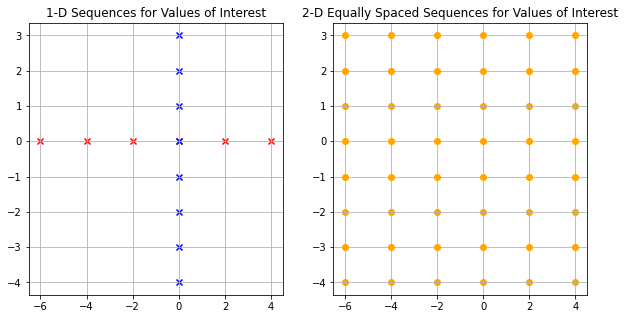

In [14]:
# Setup graph for two subgraphs
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

# Display the sequence of values for each axis
ax1.set_title('1-D Sequences for Values of Interest')
ax1.grid()
ax1.set_xticks(x_values)
ax1.set_yticks(y_values)
ax1.scatter(x_values, np.zeros(x_values.size), color="red", marker="x")
ax1.scatter(np.zeros(y_values.size), y_values, color="blue", marker="x")

# Display generated coordinates by meshgrid
ax2.set_title('2-D Equally Spaced Sequences for Values of Interest')
ax2.grid()
ax2.set_xticks(x_values)
ax2.set_yticks(y_values)
ax2.scatter(x_coordinates, y_coordinates, color="orange", marker="o")

# Display figure
fig.show()

#### Surface and Contour Plots

Having described in-depth how grids are created in _Python_, we return back to the task at hand of creating a grid of values from the cost function.

In [15]:
import numpy as np

# Define possible input and output combinations
x_seq = np.arange(-2, 2, 0.1)
y_seq = np.arange(-1, 6, 0.1)

# Form a 2D rectangular grid of coordinates across all values
xx, yy = np.meshgrid(x_seq, y_seq)

# Setup a matrix to store values of the cost J(theta) at each theta pair
J_cost_values = np.zeros(xx.shape)

# For each theta value pair, compute the cost J(theta).
for index, v in np.ndenumerate(J_cost_values):
  J_cost_values[index] = slr_cost_theta(xx[index], yy[index], X, Y)

# Calculate the ideal cost under the estimated parameters
ideal_cost_value = slr_cost_theta(hat_beta_0, hat_beta_1, X, Y)

Recall that the cost function for SLR has two parameters for $\boldsymbol\theta$. As a result, we'll need to use a **3-dimensional (3D)** graph like a **surface plot** or a **contour plot** to visualize how
the output, $z$, change as a function of $\theta_0$ and $\theta_1$. 

- **Surface plots** are a 3D plot that visualizes the third dimension ($z$) as a connected sheet of points based on two independent variables
($x$ and $y$).
- **Contour plots** are a 2D plot that has the third dimension projected into a series of slices denoting a similar "height" onto the $x$ and $y$ axes. 

#### Surface Plot


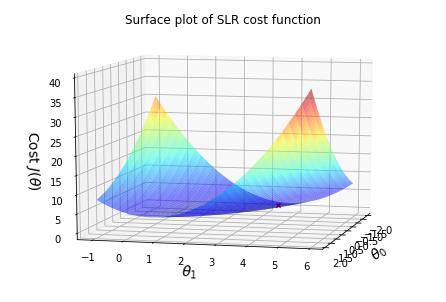

In [16]:
#@title (Hidden) Animation code for Surface Plot
# Change to allow interactivity to notebook
%matplotlib inline
# Required for plotting
from matplotlib import pyplot as plt
# Required for the 3D surface plot
from mpl_toolkits.mplot3d import Axes3D

# Custom hacking of the animation since %matplotlib notebook doesn't work.
from matplotlib import rc
import matplotlib.animation as animation
# Enable for colab
rc('animation', html='jshtml')

# Create a figure and a 3D Axes for cost graph
fig = plt.figure()
ax = Axes3D(fig)

# Graph the 3D surface of the Cost Function under Theta
ax.plot_surface(xx, yy, J_cost_values, alpha = 0.5, cmap = 'jet')
# Plot "ideal" cost under the true data generating parameters 
ax.scatter3D(hat_beta_0, hat_beta_1, ideal_cost_value, 
             marker = 'x', c="red", s=20)
ax.set_title('Surface plot of SLR cost function')
ax.set_xlabel(r'$\theta_0$', fontsize=14)
ax.set_ylabel(r'$\theta_1$', fontsize=14)
ax.set_zlabel(r'Cost $J(\theta)$', fontsize=14)

# Create a rotation around the axis
def animate(i):
    ax.view_init(elev=10., azim=14+i*12)
    return fig,

anim = animation.FuncAnimation(fig, animate,
                               frames=30, interval=300, blit=False, repeat=True)

# anim.save('my_cost_landscape.gif', writer='ffmpeg')
anim

#### Contour Plots

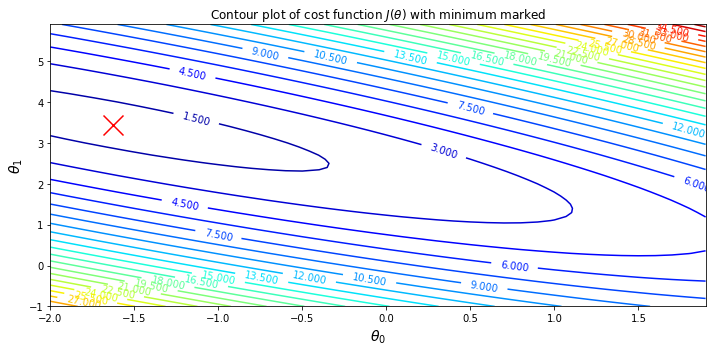

In [17]:
fig = plt.figure(figsize=(10, 5))

# Draw a contour plot for the cost function
contours = plt.contour(xx, yy, J_cost_values, 30, cmap='jet')
plt.clabel(contours, inline = True, fontsize = 10)
# Avoid filling contour plot's isobands
#plt.contourf(xx, yy, J_cost_values, 30, alpha = 0.25, cmap='jet')

# Plot the estimated parameters. 
plt.scatter(hat_beta_0, hat_beta_1, marker = 'x', c = "r", s = 400)
plt.title(r'Contour plot of cost function $J(\theta)$ with minimum marked')
plt.xlabel(r'$\theta_0$', fontsize=14)
plt.ylabel(r'$\theta_1$', fontsize=14)
plt.tight_layout()
plt.show()

#### Combined Plots

Combining together the plots yields a clearer picture of the cost landscape. 

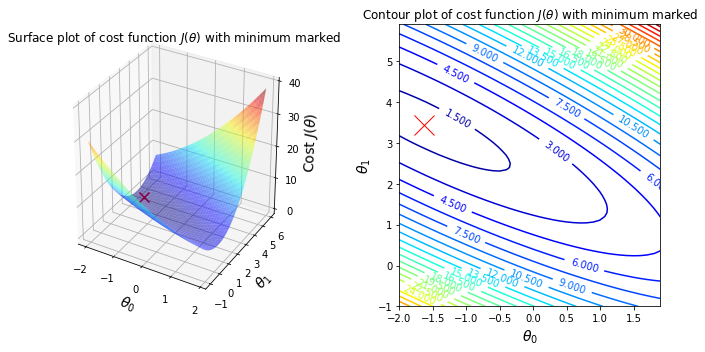

In [18]:
# Change to allow interactivity
%matplotlib inline

# Required for plotting
from matplotlib import pyplot as plt
# Required for the 3D surface plot
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122)

# Graph the 3D surface of the Cost Function under Theta
ax1.plot_surface(xx, yy, J_cost_values, alpha = 0.5, cmap = 'jet')
# Plot "ideal" cost under the true data generating parameters 
ax1.scatter3D(hat_beta_0, hat_beta_1, ideal_cost_value, 
              marker = 'x', c = 'r', s = 100)
ax1.set_title(r'Surface plot of cost function $J(\theta)$ with minimum marked')
ax1.set_xlabel(r'$\theta_0$', fontsize=14)
ax1.set_ylabel(r'$\theta_1$', fontsize=14)
ax1.set_zlabel(r'Cost $J(\theta)$', fontsize=14)

ax.view_init(elev=10., azim=90)

# Draw a contour plot for the cost function
contours = ax2.contour(xx, yy, J_cost_values, 30, cmap='jet')
ax2.clabel(contours, inline = True, fontsize = 10)
#ax2.contourf(xx, yy, J_cost_values, 30, alpha = 0.25, cmap='jet')

# Plot the true data generating parameters. 
ax2.plot(hat_beta_0, hat_beta_1, marker = 'x', c = 'r', markersize = 20)
ax2.set_title(r'Contour plot of cost function $J(\theta)$ with minimum marked')
ax2.set_xlabel(r'$\theta_0$', fontsize=14)
ax2.set_ylabel(r'$\theta_1$', fontsize=14)
fig.tight_layout()
fig.show()

To emphasize the equivalance of the plots, let's rotate the elevation and position of the surface plot to get a "top down" view of the cost function landscape.

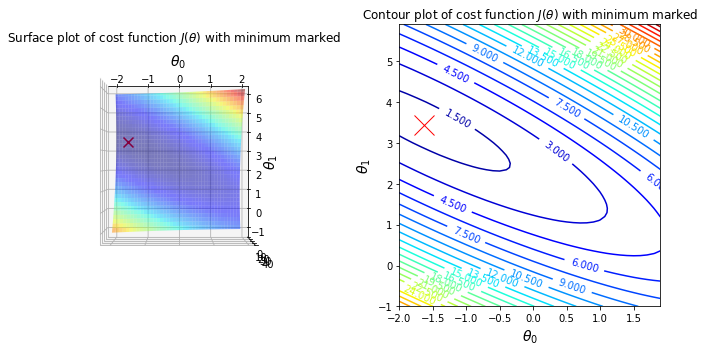

In [19]:
#@title Top-down view of surface plot
# Change to allow interactivity
%matplotlib inline

# Required for plotting
from matplotlib import pyplot as plt
# Required for the 3D surface plot
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122)

# Graph the 3D surface of the Cost Function under Theta
ax1.plot_surface(xx, yy, J_cost_values, alpha = 0.5, cmap = 'jet')
# Plot "ideal" cost under the true data generating parameters 
ax1.scatter3D(hat_beta_0, hat_beta_1, ideal_cost_value, 
              marker = 'x', c = 'r', s = 100)
ax1.set_title(r'Surface plot of cost function $J(\theta)$ with minimum marked')
ax1.set_xlabel(r'$\theta_0$', fontsize=14)
ax1.set_ylabel(r'$\theta_1$', fontsize=14)
#ax1.set_zlabel(r'$J(\theta)$', fontsize=20)

ax1.view_init(elev=90., azim=270)

# Draw a contour plot for the cost function
contours = ax2.contour(xx, yy, J_cost_values, 30, cmap='jet')
ax2.clabel(contours, inline = True, fontsize = 10)
#ax2.contourf(xx, yy, J_cost_values, 30, alpha = 0.25, cmap='jet')

# Plot the true data generating parameters. 
ax2.plot(hat_beta_0, hat_beta_1, marker = 'x', c = 'r', markersize = 20)
ax2.set_title(r'Contour plot of cost function $J(\theta)$ with minimum marked')
ax2.set_xlabel(r'$\theta_0$', fontsize=14)
ax2.set_ylabel(r'$\theta_1$', fontsize=14)
fig.tight_layout()
fig.show()

In higher dimensions, we can't easily do this. Instead, the cost history over the different parameter estimates is examined for convergence. More on this idea at the end of the notebook! 

### Solving by Random Guessing

Having seen the possible parameter values and the related effect on cost, the question becomes: "How can we find parameter values that minimize the cost function?"

For a problem like this, perhaps the best way to start is to use the tried and true method of: guessing and checking. After each guess, refine the next guess based on whether the response is close or far away to the target.


## Gradient Descent

After guessing a few times, the outcome hopefully improved. However, the question arises, can it be improved further with **better** guessing?

The answer to this question is a resounding: **Yes**, use **Gradient Descent**!

Gradient Descent is the process of updating weights by:

$$
\begin{align}
 \boldsymbol\theta_{\text{new}} := \boldsymbol\theta_{\text{old}} - \alpha \frac{\partial J(\boldsymbol\theta)}{\partial \boldsymbol\theta}\\
\end{align}
$$

where $\theta_{\text{old}}$ is the current weights and $\theta_{\text{new}}$ is the new weights.




Gradient descent improves guessing by following a function's gradient toward its minima. The rate at which it follows the gradient is controlled by $\alpha$ or the learning rate. This is a hyperparameter that needs to be tuned as:

- too high of a value will cause the minima to be missed; and
- too small of a value will require a very long, long, long time to converge.



### Gradient Descent for Simple Linear Regression

Recall, for the cost function we used the standard Mean Squared Error (MSE):

\begin{align}
 J(\boldsymbol\theta) &= \frac{1}{n} \sum_{i=1}^n (y_i - \hat{y_i})^2 \\
 & = \frac{1}{n} \sum_{i=1}^n \left[y_i - \left(\hat\theta_0 + \hat \theta_1 x_i\right)\right]^2 \\
\end{align}

Performing the partial differentiation with respect to each weight yields: 

\begin{align}
\frac{\partial J(\theta_0, \theta_1)}{\partial \theta_0} &= -\frac{2}{n} \sum_{i=1}^n \left[y_i - \left(\hat\theta_0 + \hat \theta_1 x_i\right)\right]\\
\frac{\partial J(\theta_0, \theta_1)}{\partial \theta_1} &= -\frac{2}{n} \sum_{i=1}^n \left[x_i \left(y_i - \left(\hat\theta_0 + \hat \theta_1 x_i\right)\right)\right] \\
\end{align}



So, what exactly is happening under the partial derivatives? We'll we're navigating a single variable to get as close as possible to a minimum. It's important to note, we're performing a **simultaneous** update and not a sequential update. As a result, $\boldsymbol{\theta}$ isn't updated until the last partial derivative is taken. 

In [20]:
#@title Interactive Partial Derivative Slice for Theta_0
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

# Rebuild surface plot to "highlight"
# a slope
def highlight_partial_derivative_on_surface(x, vertical_rotate = 10, horizontal_rotate = 45):
  fig = plt.figure(figsize=(12, 5))
  ax = plt.subplot(121, projection='3d')
  plt.suptitle(rf"Slice of Surface used when taking a partial derivative for $\theta_0$ when $\theta_1 = {yy[x,1]:0.02f}$")

  # Design a color scheme to only highlight the selected band
  highlight_height_3d = yy*0
  highlight_height_3d[:,:] = .3 # Fill with a single value
  highlight_height_3d[x] = 1    # Isolate band

  # Graph the surface under the colorscheme
  ax.plot_surface(xx, yy, J_cost_values, alpha = 0.5,
                  facecolors = plt.cm.viridis(highlight_height_3d))
  
  # Labels
  ax.set_xlabel(r'$\theta_0$', fontsize=14)
  ax.set_ylabel(r'$\theta_1$', fontsize=14)
  ax.set_zlabel(r'Cost $J(\theta)$', fontsize=14)

  # Enable interactive exploration
  ax.view_init(elev = vertical_rotate, azim = horizontal_rotate)
  
  # Create line graph for partial derivate from
  # slice of surface plot 
  highlight_height_2d = highlight_height_3d[:,0]
  fig.add_subplot(122)
  plt.plot(x_seq, J_cost_values[x,:], color = plt.cm.viridis(highlight_height_2d[x]))
  plt.xlabel(r'$\theta_0$', fontsize=14)
  plt.ylabel(r'Cost $J(\theta)$', fontsize=14)
  plt.show()

a = interact(highlight_partial_derivative_on_surface,
         x = widgets.IntSlider(min=0, max=69, step=1, value=10),
         horizontal_rotate = widgets.IntSlider(min=0, max=360, step=1, value=120),
         vertical_rotate = widgets.IntSlider(min=0, max=69, step=1, value=60))


interactive(children=(IntSlider(value=10, description='x', max=69), IntSlider(value=60, description='vertical_…

From here, we can now implement a function that performs gradient descent in a way that is similar to that of the normal equations for simple linear regression.

In [21]:
def slr_optimize(X, Y, alpha = 0.001, epochs = 7000):
  n = float(len(X))                          # Number of elements in X
  
  # Take a guess for parameters 
  theta_1 = np.random.randn(1)
  theta_0 = np.random.randn(1)
  cost_history = np.zeros(epochs)
  theta_history = np.zeros((epochs, 2))
  
  # Start training with gradient descent
  for i in range(epochs): 
    Y_hat = theta_1*X + theta_0               # Predicted value of Y under theta_1,0
    D_theta_0 = (-2/n) * sum(Y - Y_hat)       # Derivative under theta_0
    D_theta_1 = (-2/n) * sum(X * (Y - Y_hat)) # Derivative under theta_1
  
    # Consecutive update
    theta_0 = theta_0 - alpha * D_theta_0     # Update theta_0
    theta_1 = theta_1 - alpha * D_theta_1     # Update theta_1
    
    # Compute cost under the updated parameters
    cost = sum((Y - Y_hat)**2)/n              # Compute cost
    cost_history[i] = cost                    # Save into history

    theta_history[i,:] = [theta_0, theta_1]
  
    if i%1000 == 0:
      print(f"Epoch {i:5}") # Show cost at each 100th iteration
      print(f" Cost: {cost:.4f}")
      print(f" Parameters: theta_0 = {theta_0[0]:.4f}, theta_1 = {theta_1[0]:.4f}")

  # Display final answer in a nicely formatted manner
  display(Markdown(
  rf"""
Estimated values for """r"""$\boldsymbol{\theta}$"""

rf"""
- $\theta_0$ = {theta_0[0]:.4f}
- $\theta_1$ = {theta_1[0]:.4f}

Final cost value: {cost:.4f} 
"""
  ))

  return Y_hat, theta_0, theta_1, cost_history, theta_history

Applying the function to the data yields the following results:

In [22]:
Y_hat, hat_theta_0_gd, hat_theta_1_gd, cost_history, theta_history = slr_optimize(X, Y)

Epoch     0
 Cost: 5.1157
 Parameters: theta_0 = -1.0910, theta_1 = 1.2931
Epoch  1000
 Cost: 1.3451
 Parameters: theta_0 = -0.6349, theta_1 = 2.5665
Epoch  2000
 Cost: 1.2170
 Parameters: theta_0 = -0.8928, theta_1 = 2.8117
Epoch  3000
 Cost: 1.1486
 Parameters: theta_0 = -1.0899, theta_1 = 2.9817
Epoch  4000
 Cost: 1.1120
 Parameters: theta_0 = -1.2342, theta_1 = 3.1061
Epoch  5000
 Cost: 1.0924
 Parameters: theta_0 = -1.3399, theta_1 = 3.1971
Epoch  6000
 Cost: 1.0819
 Parameters: theta_0 = -1.4173, theta_1 = 3.2638



Estimated values for $\boldsymbol{\theta}$
- $\theta_0$ = -1.4739
- $\theta_1$ = 3.3125

Final cost value: 1.0762 


With the gradient descent routine now complete, we can check to see how 
well the solution found matches the data. 

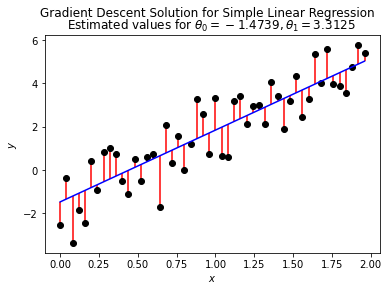

In [23]:
# Add data points
plt.scatter(X, Y, color = "black", zorder = 2) 
# Add the estimated line of best fit
plt.plot([X[0], X[-1]], [Y_hat[0], Y_hat[-1]], color='blue')  

plt.title(f'Linear Regression Solution with Gradient Descent', fontsize=12)
# Plot the residual line
plt.vlines(X, Y, Y_hat, color="red", zorder = 1)
# Provide graph labels
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(rf"Estimated values for $\theta_0 = {hat_theta_0_gd[0]:.04f}, \theta_1 = {hat_theta_1_gd[0]:.04f}$ ")
plt.suptitle("Gradient Descent Solution for Simple Linear Regression")
# Release graph
plt.show()

### Visualizing the Cost Function after Gradient Updates

When gradient descent function ran, at every 1000th epoch there was a progress snapshot presented. Once gradient descent was finished running, the value of the cost function at **each** epoch is able to be retrieved. Graphing the cost function's value by epoch provides oversight into whether the algorithm converged to a solution. 


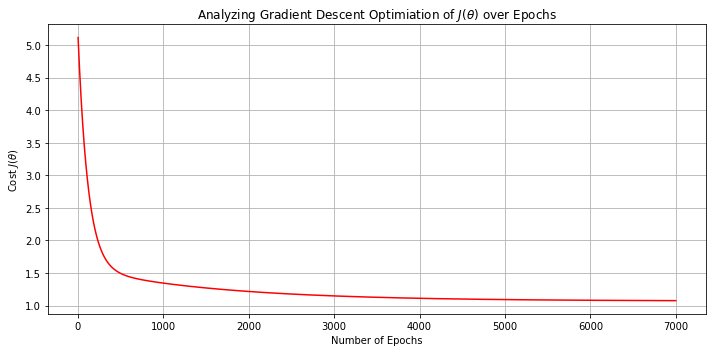

In [24]:
# Setup cost history plot
fig = plt.figure(figsize=(10, 5))
plt.xlabel('Number of Epochs')
plt.ylabel(r'Cost $J(\theta)$')
plt.title(r'Analyzing Gradient Descent Optimiation of $J(\theta)$ over Epochs')
plt.grid()
plt.plot(np.arange(cost_history.size) + 1, cost_history, 'r')
plt.tight_layout()
plt.show()

Under the **SLR**, the cost history paired with the values taken by $\boldsymbol{\theta}$ can be used to plot the trajectory of the descent on both a surface and contour plot.

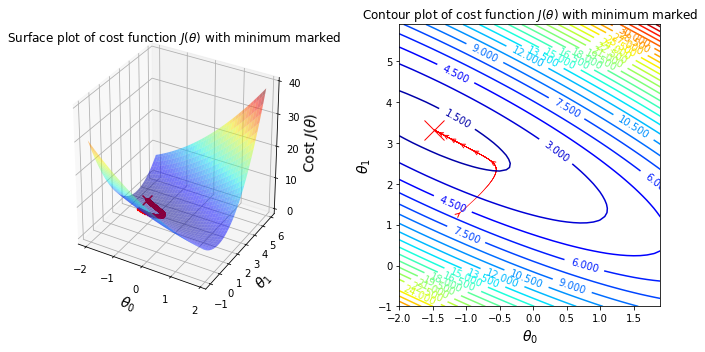

In [25]:
#@title Gradient Descent Trajectory on Cost Function
# Change to allow interactivity
%matplotlib inline

# Required for plotting
from matplotlib import pyplot as plt
# Required for the 3D surface plot
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122)

# Graph the 3D surface of the Cost Function under Theta
ax1.plot_surface(xx, yy, J_cost_values, alpha = 0.5, cmap = 'jet')

# Plot the final cost value
ax1.scatter3D(hat_theta_0_gd, hat_theta_1_gd, ideal_cost_value, 
              marker = 'x', c = 'r', s = 100)

# Graph the theta parameter descent
ax1.plot(theta_history[:, 0],
         theta_history[:, 1], 
         cost_history,
         marker = '*',
         c = 'r', markersize = 3, alpha = 0.75)

# ax1.view_init(25, 90)

# Setup surface plot axies
ax1.set_title(r'Surface plot of cost function $J(\theta)$ with minimum marked')
ax1.set_xlabel(r'$\theta_0$', fontsize=14)
ax1.set_ylabel(r'$\theta_1$', fontsize=14)
ax1.set_zlabel(r'Cost $J(\theta)$', fontsize=14)

# Compute descent vector angles for embedding a quiver plot on the contours
angles_x = theta_history[1:,0] - theta_history[:-1,0]
angles_y = theta_history[1:,1] - theta_history[:-1,1]

# Draw a contour plot for the cost function
contours = ax2.contour(xx, yy, J_cost_values, 30, cmap='jet')
ax2.clabel(contours, inline = True, fontsize = 10)
#ax2.contourf(xx, yy, J_cost_values, 30, alpha = 0.25, cmap='jet')
  
for j in range(1, angles_y.size, 1000):
  ax2.annotate('',
               xy = (theta_history[j, 0], theta_history[j, 1]),
               xytext = (theta_history[j - 1, 0], theta_history[j - 1, 1]),
               arrowprops={'arrowstyle': '->', 'color': 'r', 'lw': 1},
               va='center', ha='center')

# Plot the true data generating parameters. 
ax2.plot(hat_theta_0_gd, hat_theta_1_gd, marker = 'x', c = 'r', markersize = 20)
ax2.set_title(r'Contour plot of cost function $J(\theta)$ with minimum marked')
ax2.set_xlabel(r'$\theta_0$', fontsize=14)
ax2.set_ylabel(r'$\theta_1$', fontsize=14)

# Graph the theta parameter descent
ax2.quiver(theta_history[:-1, 0], theta_history[:-1, 1], 
          angles_x, angles_y, 
          scale_units = 'xy', angles = 'xy', scale = 1,
          color = 'r', alpha = .75)
fig.tight_layout()
fig.show()